Download dataset by following these instructions: https://www.geeksforgeeks.org/how-to-import-kaggle-datasets-directly-into-google-colab/

In [ ]:
!pip install kaggle

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/isic-2019")

print("Path to dataset files:", path)

100%|██████████| 9.10G/9.10G [07:23<00:00, 22.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/isic-2019/versions/1


In [7]:
!pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 45.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [3]:
import pandas as pd
import os

csv_file_path = os.path.join(path, "ISIC_2019_Training_GroundTruth.csv")

try:
    df = pd.read_csv(csv_file_path)
    print(df.head(5))
except FileNotFoundError:
    print(f"Error: File not found at {csv_file_path}. Please check the path.")
except Exception as e:
    print(f"An error occurred: {e}")


          image  MEL   NV  BCC   AK  BKL   DF  VASC  SCC  UNK
0  ISIC_0000000  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
1  ISIC_0000001  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
2  ISIC_0000002  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
3  ISIC_0000003  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
4  ISIC_0000004  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0


In [4]:
class_names = df.columns.tolist()[1:]
class_names

['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK']

In [5]:
import warnings
import pandas as pd
import os

# Suppress pandas warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def derive_class_index(df):
    """
    Derives the class index for each image from the ground truth CSV.
    Args:
        df: Pandas DataFrame containing the ground truth data.
    Returns:
        A pandas Series with the derived class index for each image.
    """

    df['class_index'] = -1  # Initialize with -1

    for index, row in df.iterrows():
        for i in range(1, len(row)):  # Start from the second column
            if row[i] == 1:
                df.loc[index, 'class_index'] = i-1 # Store the index (column number - 1)
                break
    return df['class_index']

# Example usage (assuming df is already loaded as in your provided code)
if 'df' in locals() and isinstance(df, pd.DataFrame):
  class_indices = derive_class_index(df)
  #print(class_indices.head(50))

  # You can now add the class indices back to the DataFrame
  # df['class_index'] = class_indices


In [6]:
print(class_indices.head(15))

0     1
1     1
2     0
3     1
4     0
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    0
13    1
14    1
Name: class_index, dtype: int64


In [7]:
class_indices.value_counts()

,count
class_index,
1,12875
0,4522
2,3323
4,2624
3,867
7,628
6,253
5,239


In [22]:
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os

# Assuming 'path' variable holds the correct directory
csv_file_path = os.path.join(path, "ISIC_2019_Training_GroundTruth.csv")

def conditional_center_crop(img):
        """Applies center crop if width or height is less than 4/5 of the other."""
        width, height = img.size
        if width < (4/5) * height or height < (4/5) * width:
            crop_size = min(width, height)  # Crop to the smaller dimension
            return transforms.CenterCrop(crop_size)(img)
        return img

class ISICDataset(Dataset):
    def __init__(self, csv_file, root_dir, classes_df, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transforms.Compose([
            transforms.Lambda(conditional_center_crop), # Conditional center crop
            transforms.Resize((128, 128)),  # Resize to 256x256
            transforms.ToTensor() # To Tensor
        ])
        self.classes = classes_df

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0] + ".jpg")
        image = Image.open(img_path).convert('RGB')
        y_label = torch.tensor(int(self.classes.iloc[index])) # Assuming class index is in the second column

        image = self.transform(image)

        return (image, y_label)


train_input_folder = os.path.join(path, "ISIC_2019_Training_Input/ISIC_2019_Training_Input")
dataset = ISICDataset(csv_file=csv_file_path, root_dir=train_input_folder, classes_df=class_indices)

first_image, first_label = dataset[0]
print(first_image.shape)
print(first_label)


torch.Size([3, 128, 128])
tensor(1)


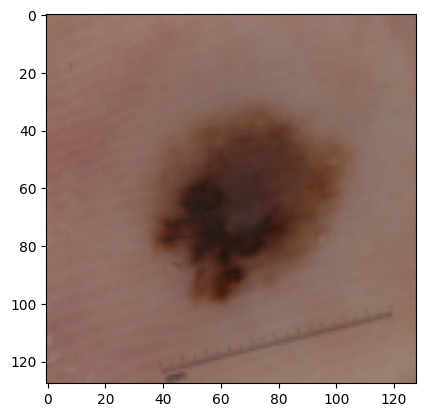

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

img, label = dataset[1623]
plt.imshow(img.permute(1, 2, 0).numpy())

In [24]:
img.shape

torch.Size([3, 128, 128])

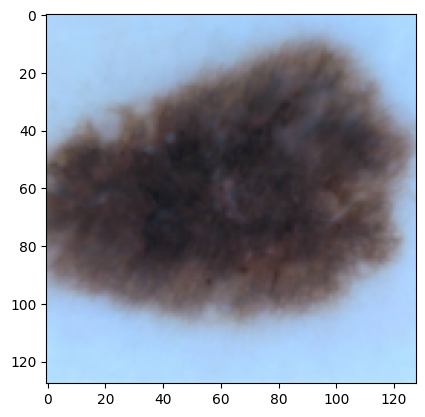

In [25]:
plt.imshow(first_image.permute(1, 2, 0).numpy())

In [26]:
class_labels = class_indices.tolist()
len(class_labels)

25331

In [27]:
import torch
from torch.utils.data import Subset, DataLoader
from sklearn.model_selection import StratifiedShuffleSplit

# we need a stratified split since there is class imbalance in the dataset
# we want all classes to be represented fairly both in the training and validation set
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

indices = list(range(len(dataset)))
train_indices, val_indices = next(sss.split(indices, class_labels))

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

# Create DataLoaders for train and validation sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [ ]:
def save_checkpoint(model, optimizer, epoch, filename):
    """Saves a checkpoint of the model and optimizer state.
    Args:
        model: The PyTorch model to save.
        optimizer: The optimizer used for training.
        epoch: The current epoch number.
        filename: The path to save the checkpoint to.
    """

    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)
    print(f"Saved checkpoint to {filename}")

In [ ]:
import torch.nn as nn
import torchvision.models as models

# load a pre-trained ResNet18 model (lightweight) -> actually EfficientNetB3 might be a better idea
# https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b3.html#torchvision.models.EfficientNet_B3_Weights
model = models.resnet18(pretrained=True)

# modify the final fully connected layer to match the number of classes, 8 here
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 8)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    train_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        # backprop and weight update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    epoch_loss = train_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Training Loss: {epoch_loss:.4f}')

    # validation loop
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, \
      Validation Accuracy: {val_accuracy:.2f}%')

    # save checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        checkpoint_filename = f'checkpoint_epoch_{epoch + 1}.pth'
        save_checkpoint(model, optimizer, epoch + 1, checkpoint_filename)
print("Training finished.")


Epoch [1/10], Step [100/317], Loss: 0.6792
Epoch [1/10], Step [200/317], Loss: 0.5490
Epoch [1/10], Step [300/317], Loss: 0.7925
Epoch [1/10], Validation Loss: 0.7299, Validation Accuracy: 73.30%
Epoch [2/10], Step [100/317], Loss: 0.8802
Epoch [2/10], Step [200/317], Loss: 0.6984
Epoch [2/10], Step [300/317], Loss: 0.4194
Epoch [2/10], Validation Loss: 0.7372, Validation Accuracy: 73.46%
Epoch [3/10], Step [100/317], Loss: 0.5439
Epoch [3/10], Step [200/317], Loss: 0.4870
Epoch [3/10], Step [300/317], Loss: 0.5648
Epoch [3/10], Validation Loss: 0.6960, Validation Accuracy: 75.00%
Epoch [4/10], Step [100/317], Loss: 0.4486
Epoch [4/10], Step [200/317], Loss: 0.4501
Epoch [4/10], Step [300/317], Loss: 0.7754
Epoch [4/10], Validation Loss: 0.7244, Validation Accuracy: 75.71%
Epoch [5/10], Step [100/317], Loss: 0.2516
Epoch [5/10], Step [200/317], Loss: 0.3614
Epoch [5/10], Step [300/317], Loss: 0.3761
Epoch [5/10], Validation Loss: 0.7493, Validation Accuracy: 76.75%
Epoch [6/10], Step [

---------------------